In [ ]:
import librosa

# Load an audio file
file_path = "/content/Snoring old/1_100.wav"  # Replace with the path to your audio file
y, sr = librosa.load(file_path, sr=None)

# Check the sampling rate
print("Sampling rate:", sr)


Sampling rate: 48000


In [ ]:
import os
import librosa
import soundfile as sf

# Define the directory containing the .wav files
directory = "/content/Snoring old"

# Define the output directory to save the files with the new sampling rate
output_directory = "/content/Snoring"

# Iterate through each .wav file in the directory
for filename in os.listdir(directory):
    if filename.endswith(".wav"):
        # Load the .wav file
        file_path = os.path.join(directory, filename)
        y, sr = librosa.load(file_path, sr=48000)  # Load with the original sampling rate

        # Resample the audio to 44,100 Hz
        y_resampled = librosa.resample(y, orig_sr=sr, target_sr=44100)

        # Save the resampled audio to a new file
        output_file_path = os.path.join(output_directory, filename)
        sf.write(output_file_path, y_resampled, 44100, subtype='PCM_16')

        print(f"Resampled {filename} to 44100 Hz and saved as {output_file_path}")


In [ ]:
import librosa

# Load an audio file
file_path = "/content/Snoring/1_100.wav"  # Replace with the path to your audio file
y, sr = librosa.load(file_path, sr=None)

# Check the sampling rate
print("Sampling rate:", sr)

Sampling rate: 44100


In [ ]:
# NEW
import os
import numpy as np
import librosa
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.utils import to_categorical

def generate_spectrogram(folder_path, file_names, sr=44100, n_fft=2048, hop_length=512, max_length=None):
    spectrograms = []
    for file_name in file_names:
        file_path = os.path.join(folder_path, file_name)
        if os.path.isfile(file_path):  # Check if it's a file
            y, _ = librosa.load(file_path, sr=sr)
            S = librosa.stft(y=y, n_fft=n_fft, hop_length=hop_length)
            spectrogram = np.abs(S)
            log_S = librosa.power_to_db(spectrogram, ref=np.max)
            if max_length is not None:  # Pad or truncate to a fixed length
                if log_S.shape[1] < max_length:
                    log_S = np.pad(log_S, ((0, 0), (0, max_length - log_S.shape[1])), mode='constant')
                elif log_S.shape[1] > max_length:
                    log_S = log_S[:, :max_length]
            spectrograms.append(log_S)
        else:
            print("Skipping directory:", file_name)
    return np.array(spectrograms)


In [ ]:
# Folder paths
snoring_folder = "/content/Snoring"
rail_folder = "/content/Rail"

# List all files in the folders
snoring_files = os.listdir(snoring_folder)
rail_files = os.listdir(rail_folder)

# Generate spectrograms for snoring and rail sounds
max_length = 128  # Maximum length of spectrograms
snoring_spectrograms = generate_spectrogram(snoring_folder, snoring_files, max_length=max_length)
rail_spectrograms = generate_spectrogram(rail_folder, rail_files, max_length=max_length)

# Labeling: 1 for snoring, 0 for rail
snoring_labels = np.ones(len(snoring_spectrograms))
rail_labels = np.zeros(len(rail_spectrograms))

# Concatenate spectrograms and labels
X = np.concatenate((snoring_spectrograms, rail_spectrograms), axis=0)
y = np.concatenate((snoring_labels, rail_labels))

In [37]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Reshape data for CNN input (add channel dimension)
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2], 1)

# Convert labels to categorical
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

# Build 2D CNN model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(X_train.shape[1], X_train.shape[2], 1)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(2, activation='softmax')  # 2 output neurons for binary classification
])

# Compile model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [38]:
# Train model
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/10
17/17 [==============================] - 3s 135ms/step - loss: 53.2420 - accuracy: 0.4944 - val_loss: 0.6379 - val_accuracy: 0.7237
Epoch 2/10
17/17 [==============================] - 2s 105ms/step - loss: 0.5772 - accuracy: 0.7312 - val_loss: 0.4342 - val_accuracy: 0.8421
Epoch 3/10
17/17 [==============================] - 2s 102ms/step - loss: 0.3840 - accuracy: 0.8289 - val_loss: 0.2083 - val_accuracy: 0.9561
Epoch 4/10
17/17 [==============================] - 2s 104ms/step - loss: 0.3356 - accuracy: 0.8459 - val_loss: 0.2190 - val_accuracy: 0.9167
Epoch 5/10
17/17 [==============================] - 2s 97ms/step - loss: 0.2373 - accuracy: 0.8985 - val_loss: 0.0814 - val_accuracy: 0.9825
Epoch 6/10
17/17 [==============================] - 2s 97ms/step - loss: 0.2371 - accuracy: 0.9361 - val_loss: 0.0905 - val_accuracy: 0.9737
Epoch 7/10
17/17 [==============================] - 2s 105ms/step - loss: 0.1538 - accuracy: 0.9492 - val_loss: 0.1568 - val_accuracy: 0.9342
Epoch 8

In [39]:
# Evaluate model
loss, accuracy = model.evaluate(X_test, y_test)
accuracy_percentage = accuracy * 100
print("Test Accuracy:", accuracy_percentage, "%")

8/8 [==============================] - 0s 30ms/step - loss: 0.0618 - accuracy: 0.9868
Test Accuracy: 98.68420958518982 %


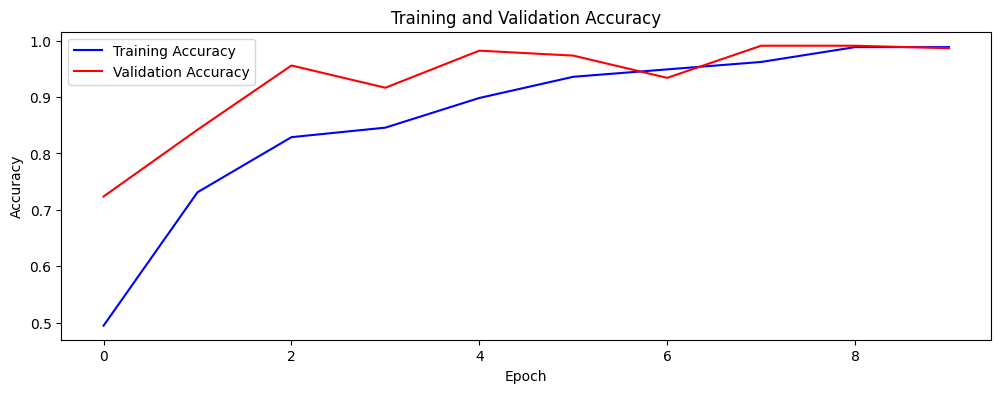

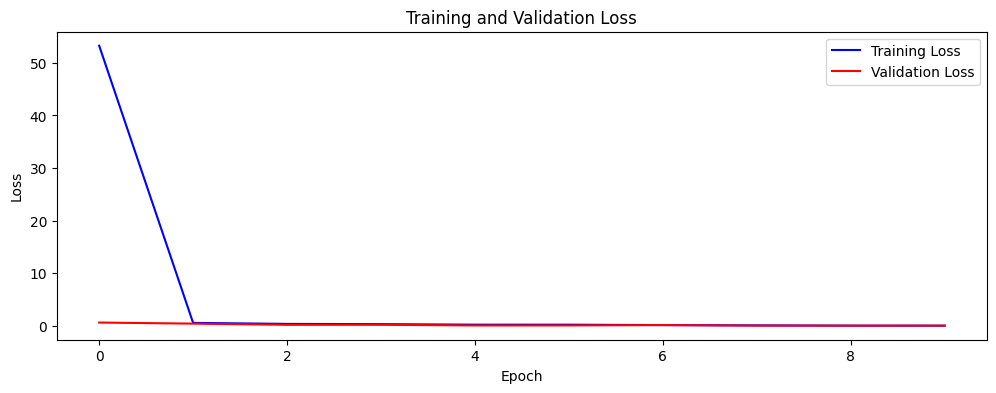

In [40]:
# Extract training and validation accuracy and loss from history
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Plot accuracy
plt.figure(figsize=(12, 4))
plt.plot(train_accuracy, label='Training Accuracy', color='blue')
plt.plot(val_accuracy, label='Validation Accuracy', color='red')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot loss
plt.figure(figsize=(12, 4))
plt.plot(train_loss, label='Training Loss', color='blue')
plt.plot(val_loss, label='Validation Loss', color='red')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


8/8 [==============================] - 0s 21ms/step
Training Metrics:
Confusion Matrix:
[[273   0]
 [  1 258]]

Sensitivity: 0.9961389961389961
Specificity: 1.0
Accuracy: 0.9981203007518797

Testing Metrics:
Confusion Matrix:
[[107   0]
 [  3 118]]

Sensitivity: 0.9752066115702479
Specificity: 1.0
Accuracy: 0.9868421052631579


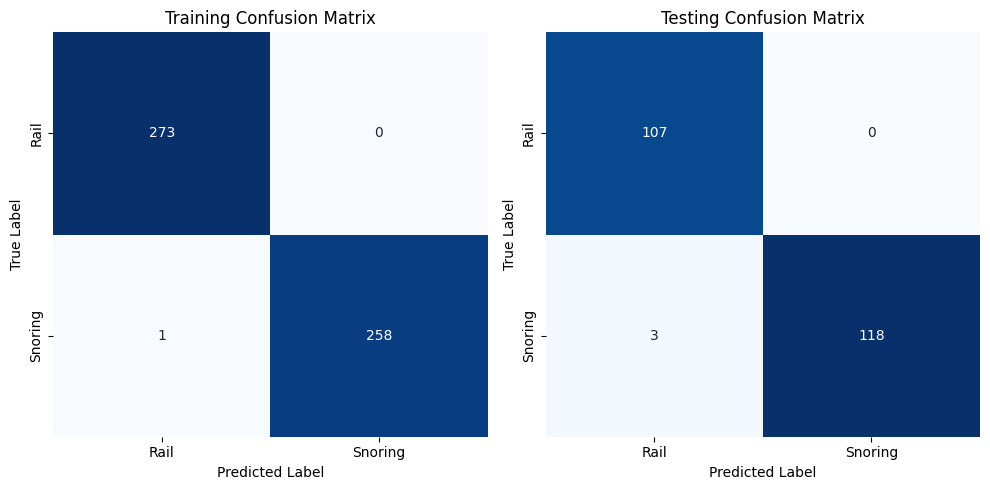

In [41]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Predict probabilities for training and testing sets
y_train_pred_prob = model.predict(X_train)
y_test_pred_prob = model.predict(X_test)

# Convert probabilities to class labels
y_train_pred = np.argmax(y_train_pred_prob, axis=1)
y_test_pred = np.argmax(y_test_pred_prob, axis=1)

# Compute confusion matrices
train_conf_matrix = confusion_matrix(np.argmax(y_train, axis=1), y_train_pred)
test_conf_matrix = confusion_matrix(np.argmax(y_test, axis=1), y_test_pred)

# Calculate sensitivity, specificity, and accuracy
train_sensitivity = train_conf_matrix[1, 1] / (train_conf_matrix[1, 1] + train_conf_matrix[1, 0])
train_specificity = train_conf_matrix[0, 0] / (train_conf_matrix[0, 0] + train_conf_matrix[0, 1])
train_accuracy = (train_conf_matrix[0, 0] + train_conf_matrix[1, 1]) / np.sum(train_conf_matrix)

test_sensitivity = test_conf_matrix[1, 1] / (test_conf_matrix[1, 1] + test_conf_matrix[1, 0])
test_specificity = test_conf_matrix[0, 0] / (test_conf_matrix[0, 0] + test_conf_matrix[0, 1])
test_accuracy = (test_conf_matrix[0, 0] + test_conf_matrix[1, 1]) / np.sum(test_conf_matrix)

# Print the results
print("Training Metrics:")
print("Confusion Matrix:")
print(train_conf_matrix)
print("\nSensitivity:", train_sensitivity)
print("Specificity:", train_specificity)
print("Accuracy:", train_accuracy)

print("\nTesting Metrics:")
print("Confusion Matrix:")
print(test_conf_matrix)
print("\nSensitivity:", test_sensitivity)
print("Specificity:", test_specificity)
print("Accuracy:", test_accuracy)

# Plot confusion matrices
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
sns.heatmap(train_conf_matrix, annot=True, cmap="Blues", fmt="d", cbar=False, xticklabels=['Rail', 'Snoring'], yticklabels=['Rail', 'Snoring'])
plt.title('Training Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

plt.subplot(1, 2, 2)
sns.heatmap(test_conf_matrix, annot=True, cmap="Blues", fmt="d", cbar=False, xticklabels=['Rail', 'Snoring'], yticklabels=['Rail', 'Snoring'])
plt.title('Testing Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

plt.tight_layout()
plt.show()


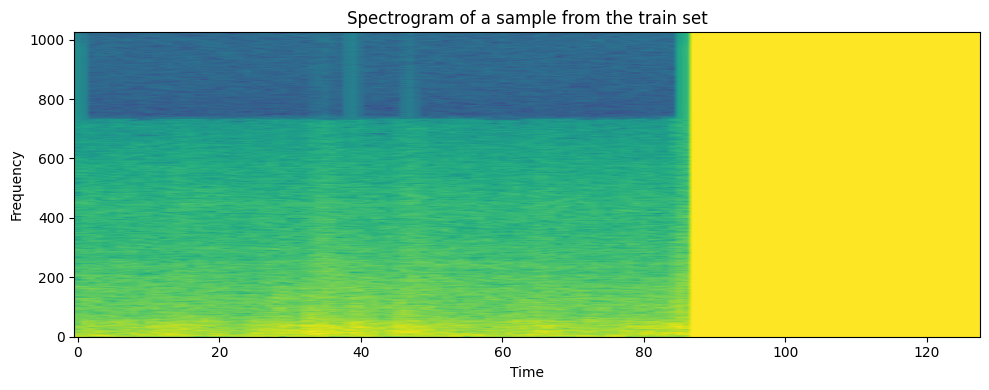

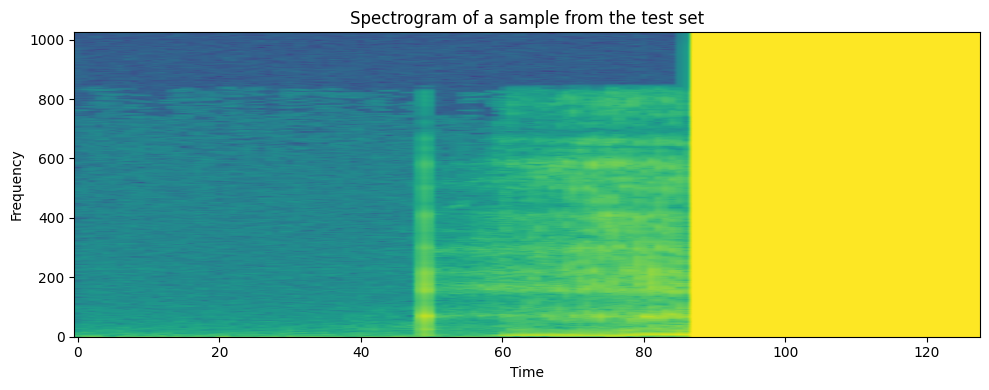

In [42]:
import matplotlib.pyplot as plt

# Function to plot a spectrogram
def plot_spectrogram(spectrogram, title):
    plt.figure(figsize=(10, 4))
    plt.imshow(spectrogram, aspect='auto', origin='lower')
    plt.title(title)
    plt.xlabel('Time')
    plt.ylabel('Frequency')
    plt.tight_layout()
    plt.show()

# Plot a spectrogram for a sample from the train set
plot_spectrogram(X_train[10], title='Spectrogram of a sample from the train set')

# Plot a spectrogram for a sample from the test set
plot_spectrogram(X_test[10], title='Spectrogram of a sample from the test set')

In [43]:
# Function to preprocess the input spectrogram
def preprocess_input_spectrogram(input_spectrogram, max_length):
    if input_spectrogram.shape[1] < max_length:
        input_spectrogram = np.pad(input_spectrogram, ((0, 0), (0, max_length - input_spectrogram.shape[1])), mode='constant')
    elif input_spectrogram.shape[1] > max_length:
        input_spectrogram = input_spectrogram[:, :max_length]
    input_spectrogram = input_spectrogram.reshape(1, input_spectrogram.shape[0], input_spectrogram.shape[1], 1)
    return input_spectrogram

# Function to detect snoring in a sound file
def detect_snoring(file_path, model, max_length=128):
    # Load sound file
    y, sr = librosa.load(file_path, sr=44100)
    # Generate spectrogram
    S = librosa.stft(y=y, n_fft=2048, hop_length=512)
    log_S = librosa.power_to_db(S, ref=np.max)
    # Preprocess spectrogram
    input_spectrogram = preprocess_input_spectrogram(log_S, max_length)
    # Predict using the model
    prediction = model.predict(input_spectrogram)
    # Return prediction
    return prediction

In [44]:
# Example usage
file_path = "/content/04Mix.wav"
prediction = detect_snoring(file_path, model)

# Check if snoring is detected
if prediction[0][1] > prediction[00][0]:  # Checking if the probability of snoring is higher than rail
    print("Snoring detected!")
else:
    print("No snoring detected.")

1/1 [==============================] - 0s 20ms/step
No snoring detected.


<ipython-input-43-426c76bab80d>:16: UserWarning: power_to_db was called on complex input so phase information will be discarded. To suppress this warning, call power_to_db(np.abs(D)**2) instead.
  log_S = librosa.power_to_db(S, ref=np.max)
